In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import random
import time

from bokeh.io import show, output_notebook
from bokeh.plotting import figure, gridplot
from bokeh.models import LinearAxis, Range1d
output_notebook()

Loading BokehJS ...

### GPU
指定使用的 GPU 编号。  
`watch -n 1 nvidia-smi` 实时查看 GPU 的运行状态。 

In [2]:
torch.cuda.set_device("cuda:3")
torch.cuda.current_device()
# device = torch.device("cuda:5")
# xxx.to(device)

3

### Data
读入 dataset 中的 `eng-fra.txt`。  

- `prepareData` 先将文本中的所有行读入，每行可以产生一个英语和法语的对，作为训练集。  
`reverse=True` 时，输入英文，输出法语；反之则颠倒。  
- 过滤：只选取英文以 `eng_prefixes` 开头的句子，且每句话最多保留10个单词，加快训练速度。  
- `class Lang` 分别保存两种语言的词库，建立词典。

In [3]:
from lang import prepareData, eng_prefixes
eng_prefixes

('i am ',
 'i m ',
 'he is',
 'he s ',
 'she is',
 'she s',
 'you are',
 'you re ',
 'we are',
 'we re ',
 'they are',
 'they re ')

Dataset, DataLoader产生自定义的训练数据，重写 Dataset 里的 `__init__`, `__len__` 和 `__getitem__` 方法。  
将 `prepareData` 以及产生训练数据的部分放入 `Dataset.__init__`，方便后面进行 load.

由于每个句子并不是统一长度，当 `train_loader.batch_size != 1` 时， 会因为句子长度不一样而失败。

In [4]:
from dataset import TorchDataset, SOS_token, EOS_token
batch_size = 1
train_data = TorchDataset('eng', 'fra', reverse=True, repeat=1)
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)

Reading lines...
../dataset/eng-fra.txt
Read 135842 sentence pairs
Trimmed to 10853 sentence pairs
Counting words...
Counted words:
fra 4489
eng 2925


In [5]:
(fra, eng), sentence = train_data[5]
print(fra)
print(eng)
print(sentence)

tensor([[ 6],
        [11],
        [14],
        [15],
        [ 5],
        [ 1]])
tensor([[2],
        [3],
        [7],
        [4],
        [1]])
['je suis en forme .', 'i m fit .']


### Model
定义编码网络和解码网络。

In [6]:
MAX_LENGTH = 10

class EncoderRNN(nn.Module):
    def __init__(self, dim_in, dim_hid, n_layers=1):
        super().__init__()
        self.n_layers = n_layers
        self.dim_hid = dim_hid
        self.embedding = nn.Embedding(dim_in, dim_hid)
        self.gru = nn.GRU(dim_hid, dim_hid)
    def forward(self, x, h):
        em = self.embedding(x).view(1, 1, -1)
        y = em
        for i in range(self.n_layers):
            y, h = self.gru(y, h)
        return y, h
    def initHidden(self):
        return torch.zeros(1, 1, self.dim_hid).cuda()
    
class AttnDecoderRNN(nn.Module):
    def __init__(self, dim_hid, dim_out, n_layers=1, dropout_prob=0.1, max_length=MAX_LENGTH):
        super().__init__()
        self.dim_hid = dim_hid
        self.dim_out = dim_out
        self.n_layers = n_layers
        self.dropout_prob = dropout_prob
        self.max_length = max_length
        
        self.embedding = nn.Embedding(self.dim_out, self.dim_hid)
        self.attn = nn.Linear(self.dim_hid*2, self.max_length)
        self.attn_combine = nn.Linear(self.dim_hid*2, self.dim_hid)
        self.dropout = nn.Dropout(self.dropout_prob)
        self.gru = nn.GRU(self.dim_hid, self.dim_hid)
        self.fc = nn.Linear(self.dim_hid, self.dim_out)
    def forward(self, x, h, encoded):
        em = self.embedding(x).view(1, 1, -1)
        em = self.dropout(em)
        
        attn_w = torch.nn.functional.softmax(self.attn(torch.cat((em[0], h[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_w.unsqueeze(0), encoded.unsqueeze(0))
        
        y = torch.cat((em[0], attn_applied[0]), 1)
        y = self.attn_combine(y).unsqueeze(0)
        
        for i in range(self.n_layers):
            y = torch.relu(y)
            y, h = self.gru(y, h)
        
        y = torch.nn.functional.log_softmax(self.fc(y[0]), dim=1)
        return y, h, attn_w

In [7]:
lrate = 0.01
epochs = 7
teacher_forcing_ratio = 0.5
hidden_size = 256

enc = EncoderRNN(train_data.lang_in.n_words, hidden_size).cuda()
dec = AttnDecoderRNN(hidden_size, train_data.lang_out.n_words, 1, dropout_prob=0.1).cuda()

criterion = nn.NLLLoss()
encoder_optim = torch.optim.SGD(enc.parameters(), lr = lrate)
decoder_optim = torch.optim.SGD(dec.parameters(), lr = lrate)

注意：每次反向传播的时候都需要将参数的梯度归零。  
`optim.step()`则在每个`Variable`的`grad`都被计算出来后，更新每个`Variable`的数值

在每次训练中都用`train_loader`中的一个`batch`作为训练数据。  
`Tensor.cuda()` 每个 `batch` 在实际使用之前，都先移入 `GPU` 后进行计算。  

2m 5s (- 29m 46s) (5000 6%) 2.9022
4m 8s (- 27m 19s) (10000 13%) 2.4035
6m 13s (- 25m 19s) (15000 19%) 2.0836
8m 21s (- 23m 23s) (20000 26%) 1.9025
10m 29s (- 21m 23s) (25000 32%) 1.6633
12m 38s (- 19m 22s) (30000 39%) 1.5298
14m 48s (- 17m 20s) (35000 46%) 1.3878
17m 0s (- 15m 17s) (40000 52%) 1.2490
19m 10s (- 13m 11s) (45000 59%) 1.1571
21m 20s (- 11m 5s) (50000 65%) 0.9769
23m 32s (- 8m 58s) (55000 72%) 1.0032
25m 39s (- 6m 49s) (60000 78%) 0.7996
27m 46s (- 4m 41s) (65000 85%) 0.8351
29m 54s (- 2m 33s) (70000 92%) 0.6273
32m 3s (- 0m 24s) (75000 98%) 0.7002


<Figure size 432x288 with 0 Axes>

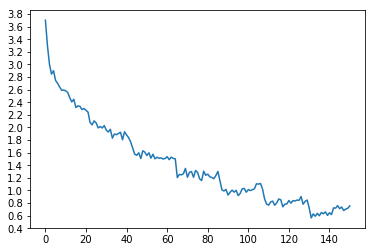

In [8]:
from plotting import timeSince, showPlot

n_iters = epochs*train_data.len
print_every = 5000
plot_every = 500
plot_loss_total = 0
print_loss_total = 0
plot_losses = []
j = 0
start = time.time()

for e in range(epochs):
    for (inputs, targets), _ in train_loader:
        encoder_optim.zero_grad()
        decoder_optim.zero_grad()
        loss = 0
        
        inputs = inputs.view(-1, 1).cuda()
        targets = targets.view(-1, 1).cuda()
        dim_in = inputs.shape[0]
        dim_out = targets.shape[0]
        
        enc_out = torch.zeros(MAX_LENGTH, enc.dim_hid).cuda()
        enc_hid = enc.initHidden()
        
        for k in range(dim_in):
            out, enc_hid = enc(inputs[k], enc_hid)
            enc_out[k] = out[0][0]
        
        dec_in = torch.LongTensor([[SOS_token]]).cuda()
        dec_hid = enc_hid
        use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False
        
        if use_teacher_forcing:
            for k in range(dim_out):
                out, dec_hid, _ = dec(dec_in, dec_hid, enc_out)
                loss += criterion(out, targets[k])
                dec_in = targets[k]
        else:
            for k in range(dim_out):
                out, dec_hid, _ = dec(dec_in, dec_hid, enc_out)
                top_v, top_i = out.data.topk(1)
                ni = top_i[0][0]
                dec_in = torch.LongTensor([[ni]]).cuda()
                loss += criterion(out, targets[k])
                if ni == EOS_token:
                    break
        
        loss.backward()
        encoder_optim.step()
        decoder_optim.step()
        
        loss = loss.data / dim_out
        
        print_loss_total += loss
        plot_loss_total += loss

        j = j + 1
        if j % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, j / n_iters),
                                         j, j / n_iters * 100, print_loss_avg))

        if j % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

showPlot(plot_losses)

### Result

In [9]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    inputs = train_data.varFromSentence(train_data.lang_in, sentence).cuda()
    dim_in = inputs.shape[0]

    enc_hid = encoder.initHidden()
    enc_out = torch.zeros(max_length, encoder.dim_hid).cuda()

    for k in range(dim_in):
        out, enc_hid = encoder(inputs[k], enc_hid)
        enc_out[k] = enc_out[k] + out[0][0]

    dec_in = torch.LongTensor([[SOS_token]]).cuda()  # SOS
    dec_hid = enc_hid

    decoded_words = []
    decoder_attentions = torch.zeros(max_length, max_length)

    for di in range(max_length):
        out, dec_hid, dec_att = decoder(dec_in, dec_hid, enc_out)
        decoder_attentions[di] = dec_att.data
        top_v, top_i = out.data.topk(1)
        ni = top_i[0][0]
        dec_in = torch.LongTensor([[ni]]).cuda()
        if ni == EOS_token:
            decoded_words.append('<EOS>')
            break
        decoded_words.append(train_data.lang_out.index2word[ni.item()])
    return decoded_words, decoder_attentions[:di + 1]

In [10]:
def showAttention(input_sentence, output_words, attentions):
    print(attentions.shape)
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') + ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(enc, dec, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)

select sentences from train dataset

In [11]:
for i, ((inputs, targets), (sen_in, sen_out)) in enumerate(train_loader):
    if i > 9: break
    sen_in = ''.join(sen_in)
    sen_out = ''.join(sen_out)
    print('>', sen_in)
    print('=', sen_out)
    outputs, attn = evaluate(enc, dec, sen_in)
    sentence = ' '.join(outputs)
    print('<', sentence)
    print('')

> vous n etes pas encore mort .
= you re not dead yet .
< you re not dead yet . <EOS>

> elle a peur des chats .
= she is afraid of cats .
< she is afraid of cats . <EOS>

> je suis fatigue de ce temps chaud .
= i m sick of this hot weather .
< i m sick of this hot weather . <EOS>

> nous avons vraiment peur .
= we re really scared .
< we re really scared . <EOS>

> tu n es pas indispensable .
= you re replaceable .
< you re not . <EOS>

> je vais sortir cet apres midi .
= i m going to go out this afternoon .
< i am going to go out out . <EOS>

> nous n y sommes pas prets .
= we re not ready for this .
< we re not ready for this . <EOS>

> ils ont des ennuis .
= they re in trouble .
< they re in trouble . <EOS>

> il a des chances de remporter le jeu .
= he is likely to win the game .
< he is likely to win the game . <EOS>

> elle travaille dur ce semestre .
= she is working hard this semester .
< she is working hard this work . <EOS>



use new sentences

input = je suis trop froid .
output = i am too too . <EOS>
torch.Size([6, 10])


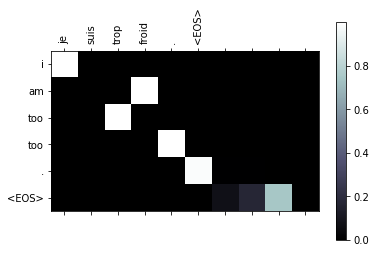

input = elle a cinq ans de moins que moi .
output = she s five years younger than me . <EOS>
torch.Size([9, 10])


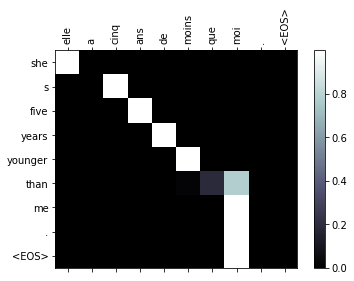

input = elle est trop petit .
output = she is too short . <EOS>
torch.Size([6, 10])


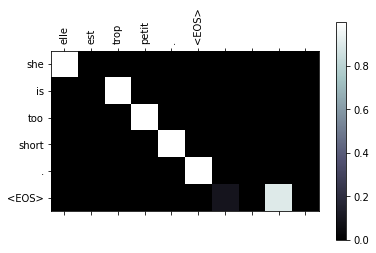

input = je ne crains pas de mourir .
output = i m not scared to die . <EOS>
torch.Size([8, 10])


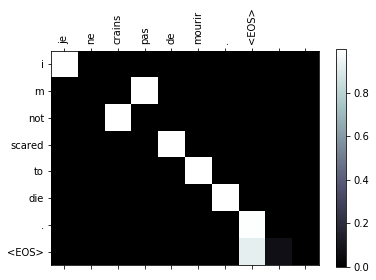

input = c est un jeune directeur plein de talent .
output = he is a smart young drunk . <EOS>
torch.Size([8, 10])


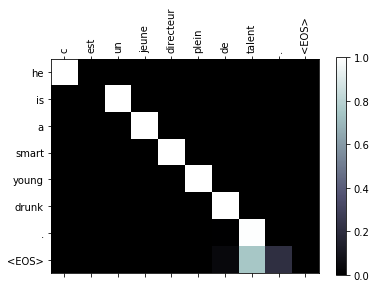

In [12]:
evaluateAndShowAttention("je suis trop froid .")
evaluateAndShowAttention("elle a cinq ans de moins que moi .")
evaluateAndShowAttention("elle est trop petit .")
evaluateAndShowAttention("je ne crains pas de mourir .")
evaluateAndShowAttention("c est un jeune directeur plein de talent .")

### Save Model

In [13]:
torch.save(enc.state_dict(), 'seq2seq-enc-cuda.pkl')
torch.save(dec.state_dict(), 'seq2seq-dec-cuda.pkl')

### Load Model

In [14]:
enc.load_state_dict(torch.load('seq2seq-enc-cuda.pkl'))
dec.load_state_dict(torch.load('seq2seq-dec-cuda.pkl'))

<All keys matched successfully>